In [1]:
import laspy as lp
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from optical_group_5.points2dem import dem, classes

In [2]:
f = lp.read("../../data/ALS2018_UP_Golm_06May2018_RGB.laz")

## Gen data

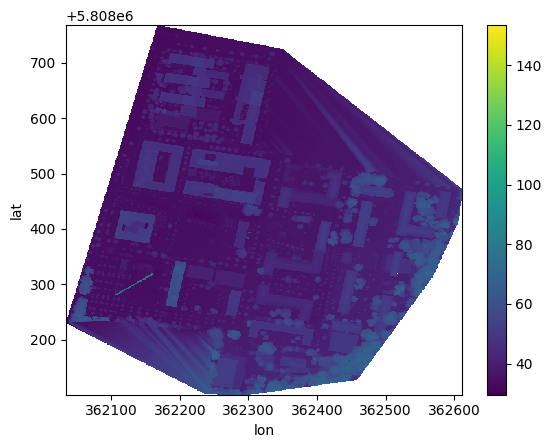

In [3]:
dsm = dem(f, interp=True)
dsm.plot.imshow()

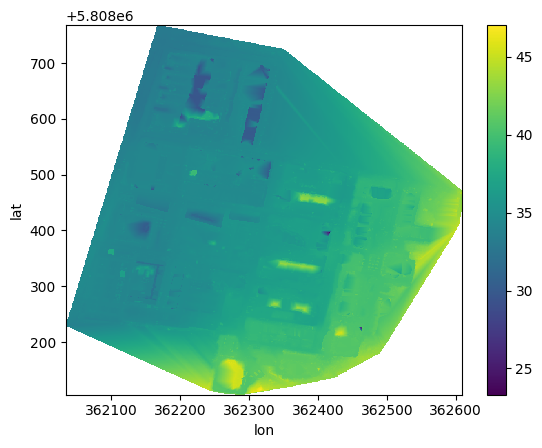

In [4]:
dtm = dem(f, interp=True, keep_class=2)
dtm.plot.imshow()

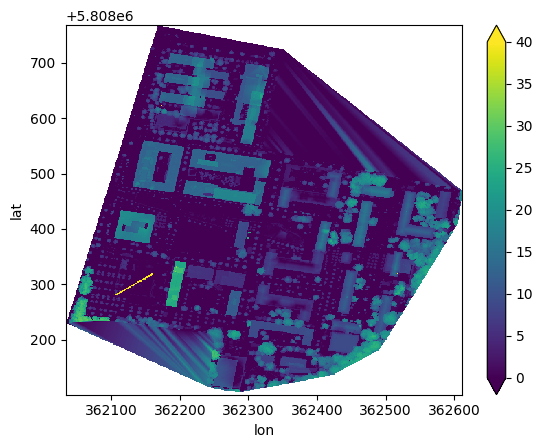

In [5]:
rh = (dsm - dtm.interp_like(dsm))
rh.plot.imshow(vmin=0, vmax=40)

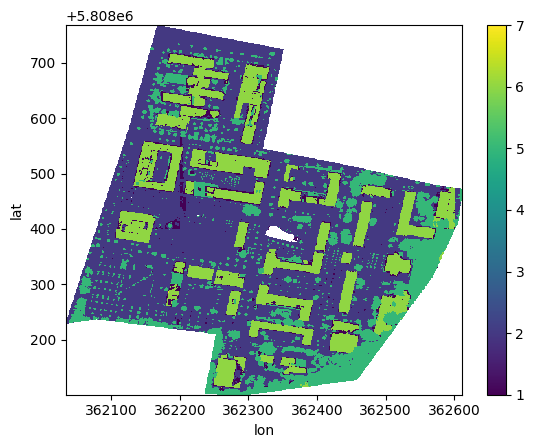

In [6]:
c = classes(f)
c = c.where(c != 0, np.nan)
c.plot.imshow()

## Clip data

In [7]:
# Align the rasters
dtm = dtm.interp_like(dsm)
rh = rh.interp_like(dsm)
c = c.interp_like(dsm)

<Axes: >

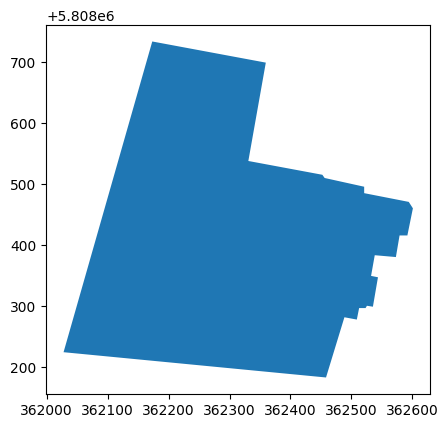

In [31]:
gdf = gpd.read_file("../../data/CampusGolm_Clipper.gpkg")
gdf.plot()

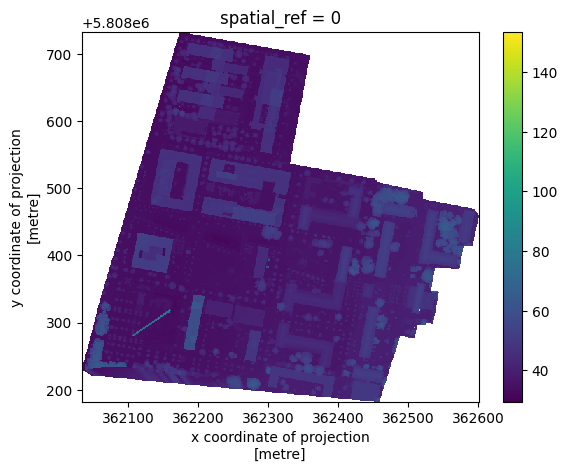

In [9]:
# Clip the raster to the bounding box of the geodataframe
dsm = dsm.rio.write_crs(gdf.crs)
dsm = dsm.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
dsm = dsm.rio.clip(gdf.geometry)
dsm.plot.imshow()

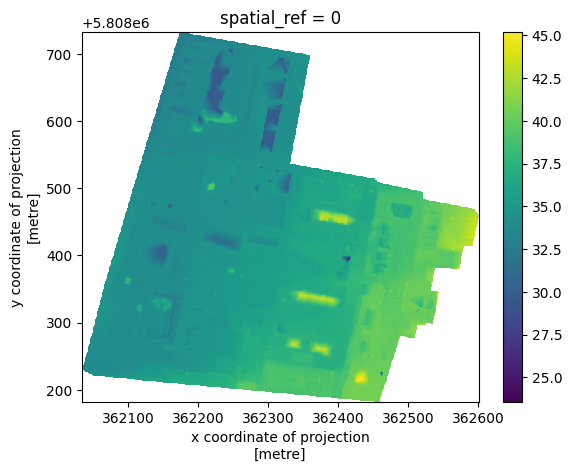

In [10]:
dtm = dtm.rio.write_crs(gdf.crs)
dtm = dtm.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
dtm = dtm.rio.clip(gdf.geometry)
dtm.plot.imshow()

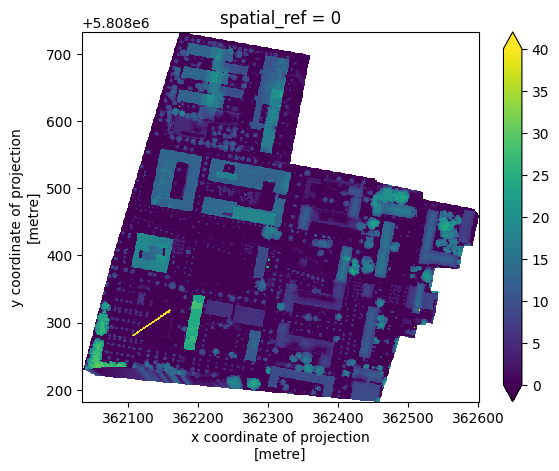

In [11]:
rh = rh.rio.write_crs(gdf.crs)
rh = rh.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
rh = rh.rio.clip(gdf.geometry)
rh.plot.imshow(vmin=0, vmax=40)

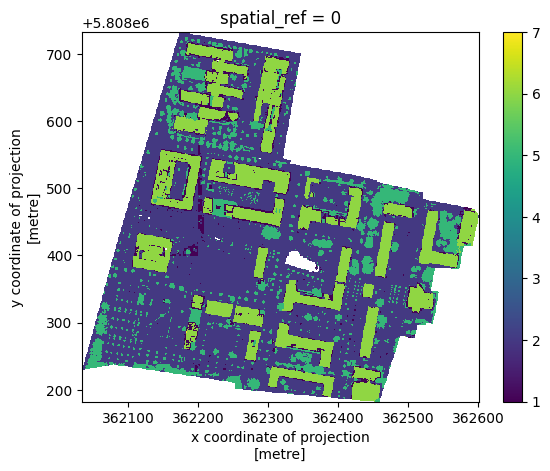

In [12]:
c = c.rio.write_crs(gdf.crs)
c = c.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
c = c.rio.clip(gdf.geometry)
c.plot.imshow()

## Store as NetCDF

In [13]:
# Add metdata to the rasters
dsm.name = "DSM"
dsm.attrs["units"] = "m"
dsm.attrs["long_name"] = "Digital Surface Model"

dtm.name = "DTM"
dtm.attrs["units"] = "m"
dtm.attrs["long_name"] = "Digital Terrain Model"

rh.name = "Relative_Height"
rh.attrs["units"] = "m"
rh.attrs["long_name"] = "Relative Height"

c.name = "Classes"
c.attrs["long_name"] = "Classification"

In [14]:
ds = xr.Dataset(
    {
        "dsm": dsm,
        "dtm": dtm,
        "rh": rh,
        "classes": c,
    }
)
ds

<xarray.Dataset> Size: 10MB
Dimensions:      (lat: 551, lon: 567)
Coordinates:
  * lat          (lat) float64 4kB 5.808e+06 5.808e+06 ... 5.809e+06 5.809e+06
  * lon          (lon) float64 5kB 3.62e+05 3.62e+05 ... 3.626e+05 3.626e+05
    spatial_ref  int32 4B 0
Data variables:
    dsm          (lat, lon) float64 2MB nan nan nan nan nan ... nan nan nan nan
    dtm          (lat, lon) float64 2MB nan nan nan nan nan ... nan nan nan nan
    rh           (lat, lon) float64 2MB nan nan nan nan nan ... nan nan nan nan
    classes      (lat, lon) float64 2MB nan nan nan nan nan ... nan nan nan nan

In [15]:
import numpy as np

# Assuming `ds` is the xarray Dataset variable
classes = ds['classes'].values
unique_classes = np.unique(classes)
print(unique_classes)

[ 1.  2.  5.  6.  7. nan]


In [16]:
ds.to_netcdf("../../data/dem_golm.nc")

## Plot it

In [17]:
def plot_categorical(da, ax):
    categories = ["Created", "Unclassified", "Ground", "Low Vegetation", "Medium Vegetation", "High Vegetation", "Building", "Noise"]
    cmap = plt.get_cmap("tab20").resampled(8)
    norm = mcolors.BoundaryNorm(np.arange(-0.5, len(categories)), cmap.N)
    im = da.plot.imshow(ax=ax, cmap=cmap, norm=norm)
    im.colorbar.set_ticks(np.arange(0, len(categories)))
    im.colorbar.set_ticklabels(categories)
    im.colorbar.set_label("Classes")

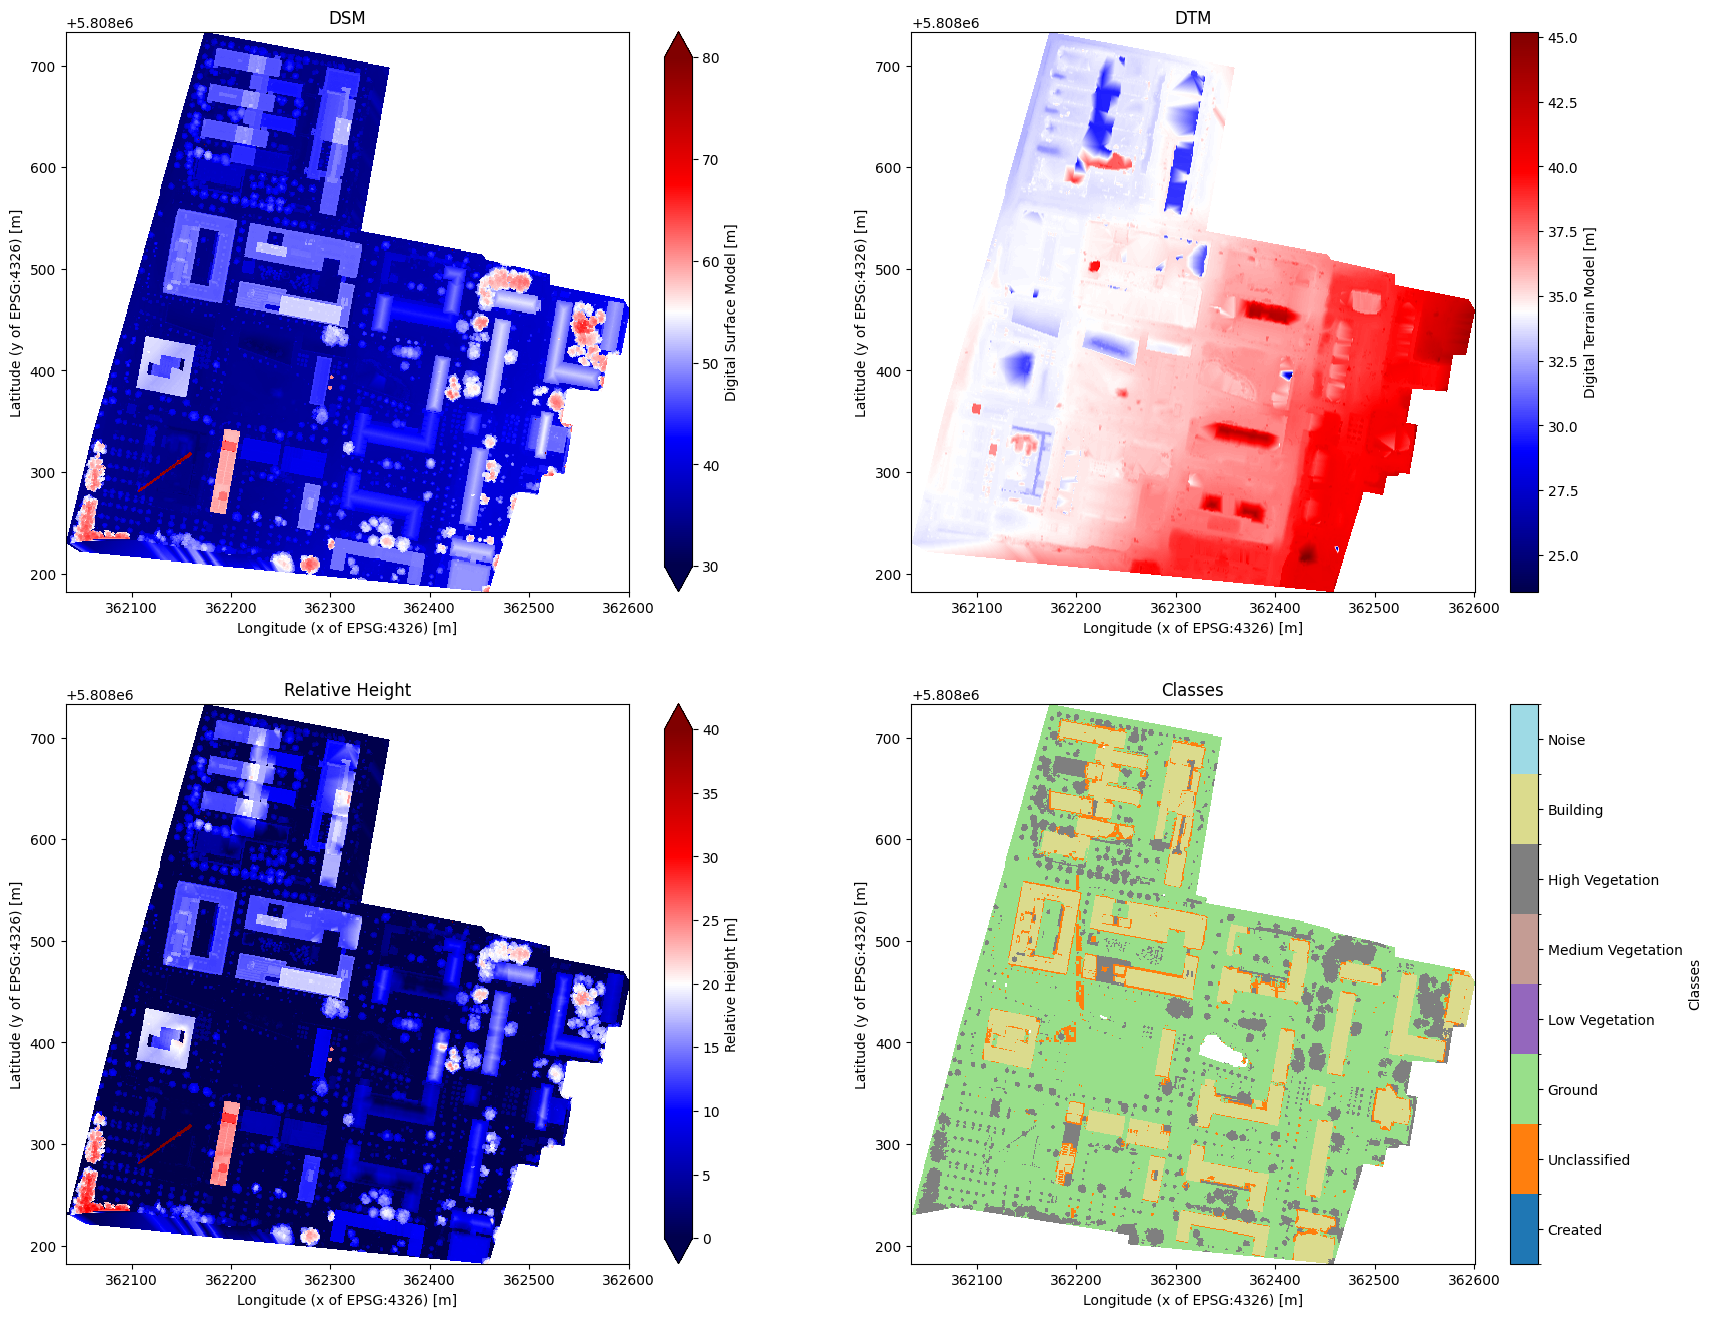

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

ds.dsm.plot.imshow(ax=axs[0, 0], vmin=30, vmax=80, cmap="seismic")
ds.dtm.plot.imshow(ax=axs[0, 1], cmap="seismic")
ds.rh.plot.imshow(ax=axs[1, 0], vmin=0, vmax=40, cmap="seismic")
plot_categorical(ds.classes, axs[1, 1])

axs[0, 0].set_title("DSM")
axs[0, 1].set_title("DTM")
axs[1, 0].set_title("Relative Height")
axs[1, 1].set_title("Classes")

for ax in axs.flat:
    ax.set_ylabel("Latitude (y of EPSG:4326) [m]")
    ax.set_xlabel("Longitude (x of EPSG:4326) [m]")

plt.show()

In [32]:
def plot_single_categorical_height(da, ax, height, categorie, height_min, height_max):
    # Create a mask for the specified class and the height range
    mask = (da == categorie) & (height >= height_min) & (height <= height_max)

    # Apply the mask to the height data
    height_masked = xr.where(mask, height, np.nan)

    # Plot the masked height data
    im = height_masked.plot.imshow(ax=ax, cmap='seismic')
    
    return im

In [34]:
from ipywidgets import interact

# Define a dictionary for the class names and values
class_dict = {"High Vegetation": 5, "Building": 6}

# Define a function for updating the plot
def update_plot(class_val=2, height_min=0, height_max=50):

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    im = plot_single_categorical_height(ds.classes, ax, ds.rh, class_val, round(height_min, 2), round(height_max, 2))
    
    # Find the class name corresponding to the class value
    class_name = [name for name, value in class_dict.items() if value == class_val][0]
    
    #configure the plot
    ax.set_title(f"Relative height for {class_name} between {round(height_min, 2)} and {round(height_max, 2)} meters")
    ax.set_ylabel("Latitude (y of EPSG:4326) [m]")
    ax.set_xlabel("Longitude (x of EPSG:4326) [m]")
    plt.show()

# Create interactive widgets for class and height
_ = interact(update_plot, class_val=class_dict, height_min=(0, 37, 0.1), height_max=(1, 37, 0.1))

interactive(children=(Dropdown(description='class_val', options={'High Vegetation': 5, 'Building': 6}, value=5…